In [1]:
import os

import torch
import numpy as np
import pandas as pd

import mne

import scipy.io
import scipy
import scipy.signal

from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import re
import multiprocessing

from collections import Counter

import random

In [2]:
data_path = "/home/oturgut/data/LEMON/eeg/"

2dos: 0.1Hz and 49Hz; all channels; entire recording

### Parse the header file

In [3]:
participant_tab_data = pd.read_csv(os.path.join(data_path, "..", "Participants_LEMON.csv"), index_col=0)
display(participant_tab_data[:5])

,Gender_ 1=female_2=male,Age
sub-032301,1,65-70
sub-032302,1,20-25
sub-032303,1,65-70
sub-032304,2,25-30
sub-032305,1,65-70


In [4]:
labels_dict = {}
for idx in range(len(participant_tab_data)):
    key = participant_tab_data.index[idx]
    sex = participant_tab_data.iloc[idx]["Gender_ 1=female_2=male"]
    age = np.array([int(age) for age in participant_tab_data.iloc[idx]["Age"].split("-")], dtype=np.float32).mean()

    labels_dict[key] = (age, sex)
print(len(labels_dict))
display(list(labels_dict.items())[:5])

# torch.save(labels_dict, "/home/oturgut/data/processed/lemon/labels_dict.pt")

228


[('sub-032301', (67.5, 1)),
 ('sub-032302', (22.5, 1)),
 ('sub-032303', (67.5, 1)),
 ('sub-032304', (27.5, 2)),
 ('sub-032305', (67.5, 1))]

### Create the raw dataset

In [5]:
def get_all_files(rootdir, substring):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)

        if os.path.isdir(curr_object):
            files += get_all_files(curr_object, substring)
        elif substring in file and ".set" in file:
            files.append(curr_object)

    return files

In [6]:
# eyes closed
ec_files = get_all_files(data_path, 'EC')
ec_files = sorted(ec_files)

print(len(ec_files))
display(ec_files[:5])

202


['/home/oturgut/data/LEMON/eeg/sub-032301/sub-032301_EC.set',
 '/home/oturgut/data/LEMON/eeg/sub-032302/sub-032302_EC.set',
 '/home/oturgut/data/LEMON/eeg/sub-032303/sub-032303_EC.set',
 '/home/oturgut/data/LEMON/eeg/sub-032304/sub-032304_EC.set',
 '/home/oturgut/data/LEMON/eeg/sub-032305/sub-032305_EC.set']

In [7]:
# eyes open
eo_files = get_all_files(data_path, 'EO')
eo_files = sorted(eo_files)

print(len(eo_files))
display(eo_files[:5])

202


['/home/oturgut/data/LEMON/eeg/sub-032301/sub-032301_EO.set',
 '/home/oturgut/data/LEMON/eeg/sub-032302/sub-032302_EO.set',
 '/home/oturgut/data/LEMON/eeg/sub-032303/sub-032303_EO.set',
 '/home/oturgut/data/LEMON/eeg/sub-032304/sub-032304_EO.set',
 '/home/oturgut/data/LEMON/eeg/sub-032305/sub-032305_EO.set']

In [8]:
def get_min_length(filenames, resampling_freq=100):
    min_length = 1000000
    min_sample = ''

    max_length = 0
    max_sample = ''

    nb_samples = 0

    for file in filenames:
        nb_samples += 1

        raw_data = mne.io.read_raw_eeglab(input_fname=file, verbose=False)

        sfreq = raw_data.info["sfreq"]
        time_points = int(raw_data.__len__() * resampling_freq / sfreq)

        if min_length > time_points:
            min_length = time_points
            min_sample = file

        if max_length < time_points:
            max_length = time_points
            max_sample = file

    # print("Min sample: ", min_sample)
    print("Min length: ", min_length)

    # print("Max sample: ", max_sample)
    print("Max length: ", max_length)

    # print(nb_samples)

    return min_length

s_freq = 500

min_length_ec = get_min_length(ec_files, resampling_freq=s_freq)
min_length_eo = get_min_length(eo_files, resampling_freq=s_freq)

print(min_length_ec)
print(min_length_eo)

In [10]:
data_raw = mne.io.read_raw_eeglab(ec_files[0], verbose=False)
print(data_raw.ch_names)

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'AFz', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT7', 'FC3', 'FC4', 'FT8', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']


/tmp/ipykernel_807458/1782339012.py:1: RuntimeWarning: Data file name in EEG.data (sub-010002_EC.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032301_EC.fdt).
  data_raw = mne.io.read_raw_eeglab(ec_files[0], verbose=False)
/tmp/ipykernel_807458/1782339012.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data_raw = mne.io.read_raw_eeglab(ec_files[0], verbose=False)
/tmp/ipykernel_807458/1782339012.py:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data_raw = mne.io.read_raw_eeglab(ec_files[0], verbose=False)


In [ ]:
def get_channels(edf_filename):
    # Extract subject ID from the file name
    subject_id = re.search(r'/([^/]+)\.set', edf_filename).group(1)

    try:
        # Read the EEG data from the .edf file
        raw = mne.io.read_raw_eeglab(edf_filename, verbose=False)

        return subject_id, raw.ch_names

    except Exception as e:
        return subject_id, None

if __name__ == "__main__":
    num_processes = 32
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = list(pool.map(get_channels, sorted(ec_files+eo_files)[:]))

    # Extract results into separate lists
    subject_ids, channel_names = zip(*results)

    subject_ids = [idx for idx in subject_ids if idx is not None]
    channel_names = [ch_names for ch_names in channel_names if ch_names is not None]

In [14]:
# Flatten the list of lists
flat_channel_names = [channel for subject_channels in channel_names for channel in subject_channels]

# Use Counter to get unique channel names and their counts
channel_counts = Counter(flat_channel_names)

# List with the most occuring (i.e. > 0.8*len(channel_names)) channel names
most_common_channels = []

# Print unique channel names and their counts
for channel, count in channel_counts.items():
    # print(f"{channel}: {count} occurrences")
    if count > 400: # (len(channel_names)*0.8):
        most_common_channels.append(channel)

print(len(most_common_channels))
print(most_common_channels)

32
['F3', 'F4', 'FC5', 'C3', 'C4', 'CP5', 'P3', 'Pz', 'P4', 'P8', 'Oz', 'O2', 'AF3', 'AF4', 'F1', 'F2', 'FT7', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CPz', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO3', 'POz', 'PO4', 'PO8']


In [18]:
channel_counts

Counter({'F4': 404,
         'C3': 404,
         'CP5': 404,
         'Pz': 404,
         'P4': 404,
         'P8': 404,
         'Oz': 404,
         'AF3': 404,
         'C2': 404,
         'CP3': 404,
         'P5': 404,
         'P1': 404,
         'P2': 404,
         'P6': 404,
         'PO3': 404,
         'PO4': 404,
         'PO8': 404,
         'C4': 403,
         'O2': 403,
         'AF4': 403,
         'F1': 403,
         'F3': 402,
         'P3': 402,
         'F2': 402,
         'FT7': 402,
         'C5': 402,
         'C1': 402,
         'CPz': 402,
         'POz': 402,
         'FC5': 401,
         'C6': 401,
         'TP8': 401,
         'CP2': 400,
         'AFz': 400,
         'P7': 400,
         'O1': 400,
         'F5': 400,
         'FC3': 400,
         'FC4': 400,
         'CP4': 400,
         'PO7': 400,
         'F6': 399,
         'F8': 398,
         'CP1': 398,
         'AF8': 398,
         'FC2': 397,
         'Fz': 395,
         'FC1': 394,
         'FC6': 39

In [15]:
chOrder_standard = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

In [ ]:
def extract_channels_and_waveform(edf_filename, normalise=True):
    # Extract subject ID from the file name
    subject_id = re.search(r'/([^/]+)\.set', edf_filename).group(1)

    sampling_frequency = 250 # Hz
    tmin = 15   # seconds
    tmax = 315  # seconds

    try:
        # Read the EEG data from the .edf file
        data_raw = mne.io.read_raw_eeglab(edf_filename, verbose=False)

        drop_channels = [ch for ch in data_raw.ch_names if ch not in chOrder_standard]
        
        if drop_channels is not None:
            useless_chs = []
            for ch in drop_channels:
                if ch in data_raw.ch_names:
                    useless_chs.append(ch)
            data_raw.drop_channels(useless_chs)

        if chOrder_standard is not None and len(chOrder_standard) == len(data_raw.ch_names):
            data_raw.reorder_channels(chOrder_standard)
        elif chOrder_standard is not None:
            # if the recording does not have all the chOrder_standard channels 
            return subject_id, None, [ch for ch in chOrder_standard if ch not in data_raw.ch_names], edf_filename

        if data_raw.ch_names != chOrder_standard:
            raise Exception("channel order is wrong!")

        data = data_raw.crop(tmin=tmin, tmax=tmax, verbose=False).load_data(verbose=False)._data

        if normalise:
            data = ( data - data.mean(axis=-1, keepdims=True) ) / ( data.std(axis=-1, keepdims=True) + 1e-9 )

        return subject_id, data, data_raw.ch_names, edf_filename
    
    except Exception as e:
        return subject_id, None, str(e), edf_filename


if __name__ == "__main__":
    num_processes = 24
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(extract_channels_and_waveform, sorted(ec_files+eo_files))

    # Collect the results into a dictionary
    data_dict = {result[0]: (torch.tensor(result[1], dtype=torch.float32), result[2], result[3]) for result in results if result[1] is not None}

In [ ]:
# OUTDATED

# def extract_channels_and_waveform(edf_filename):
#     # Extract subject ID from the file name
#     subject_id = re.search(r'/([^/]+)\.set', edf_filename).group(1)

#     sampling_frequency = 250 # Hz
#     tmin = 15   # seconds
#     tmax = 315  # seconds

#     try:
#         # Read the EEG data from the .edf file
#         raw = mne.io.read_raw_eeglab(edf_filename, verbose=False)

#         # Get the selected channels and their indices
#         selected_channels = [channel for channel in raw.ch_names if channel in most_common_channels]

#         if len(selected_channels) == 32:
#             picks = raw.pick(selected_channels, verbose=False).crop(tmin=tmin, tmax=tmax, verbose=False).load_data(verbose=False).resample(sfreq=sampling_frequency, verbose=False)

#             # Convert the data to a PyTorch tensor
#             waveform_tensor = picks._data

#             return subject_id, waveform_tensor, selected_channels, edf_filename
#             # return subject_id, None, selected_channels, edf_filename
#         else:
#             return subject_id, None, selected_channels, edf_filename
#             # return subject_id, None, None, edf_filename

#     except Exception as e:
#         return subject_id, None, str(e), edf_filename
#         # return subject_id, None, None, edf_filename

# if __name__ == "__main__":
#     num_processes = 32
#     with multiprocessing.Pool(processes=num_processes) as pool:
#         results = pool.map(extract_channels_and_waveform, sorted(ec_files+eo_files))

#     # Collect the results into a dictionary
#     data_dict = {result[0]: (torch.tensor(result[1], dtype=torch.float32), result[2], result[3]) for result in results if result[1] is not None}
#     # torch.save(data_dict, "/home/oturgut/data/processed/lemon/data_dict.pt")

In [28]:
len(results)

404

In [ ]:
# ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

In [37]:
results[16]

('sub-032310_EC',
 None,
 ['T7', 'T8'],
 '/home/oturgut/data/LEMON/eeg/sub-032310/sub-032310_EC.set')

In [38]:
data_raw = mne.io.read_raw_eeglab('/home/oturgut/data/LEMON/eeg/sub-032310/sub-032310_EC.set', verbose=False)
print(data_raw.ch_names)

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'C3', 'Cz', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'AFz', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT7', 'FC3', 'FC4', 'FT8', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']


/tmp/ipykernel_807458/1716036108.py:1: RuntimeWarning: Data file name in EEG.data (sub-010016_EC.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032310_EC.fdt).
  data_raw = mne.io.read_raw_eeglab('/home/oturgut/data/LEMON/eeg/sub-032310/sub-032310_EC.set', verbose=False)
/tmp/ipykernel_807458/1716036108.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data_raw = mne.io.read_raw_eeglab('/home/oturgut/data/LEMON/eeg/sub-032310/sub-032310_EC.set', verbose=False)
/tmp/ipykernel_807458/1716036108.py:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data_raw = mne.io.read_raw_eeglab('/home/oturgut/data/LEMON/eeg/sub-032310/sub-032310_EC.set', verbose=False)


In [29]:
len(data_dict)

264

### Create the data split

In [12]:
print(len(data_dict))
print(list(data_dict.keys())[:5])

378
['sub-032301_EC', 'sub-032301_EO', 'sub-032302_EC', 'sub-032302_EO', 'sub-032303_EC']


In [13]:
print(len(labels_dict))
print(list(labels_dict.keys())[:5])

228
['sub-032301', 'sub-032302', 'sub-032303', 'sub-032304', 'sub-032305']


In [14]:
subject_ids = sorted(list(set([subj_id.split("_")[0] for subj_id in list(data_dict.keys())])))
print(len(subject_ids))
print(subject_ids[:5])

194
['sub-032301', 'sub-032302', 'sub-032303', 'sub-032304', 'sub-032305']


EITHER: Create random train, val, test split

In [71]:
random.shuffle(subject_ids)
print(subject_ids[:5])

['sub-032360', 'sub-032306', 'sub-032326', 'sub-032323', 'sub-032343']


In [72]:
data_train, labels_train = [], []
data_val, labels_val = [], []
data_test, labels_test = [], []

# total time in steps
ttime = 30000

total_nb_subjects = len(subject_ids)
for idx, subj in enumerate(subject_ids):
    if idx >= 0.85*total_nb_subjects:
        # test 15 %
        try: # eyes closed
            data_test.append(data_dict[subj+"_EC"][0][..., :ttime])
            labels_test.append(labels_dict[subj][0])
        except:
            pass

        try: # eyes open
            data_test.append(data_dict[subj+"_EO"][0][..., :ttime]) 
            labels_test.append(labels_dict[subj][0])
        except: 
            pass
    elif idx >= 0.7*total_nb_subjects:
        # val 15 %
        try: # eyes closed
            data_val.append(data_dict[subj+"_EC"][0][..., :ttime]) 
            labels_val.append(labels_dict[subj][0])
        except:
            pass
            
        try: # eyes open
            data_val.append(data_dict[subj+"_EO"][0][..., :ttime]) 
            labels_val.append(labels_dict[subj][0])
        except:
            pass
    else:
        try: # eyes closed
            data_train.append(data_dict[subj+"_EC"][0][..., :ttime]) 
            labels_train.append(labels_dict[subj][0])
        except:
            pass
            
        try: # eyes open
            data_train.append(data_dict[subj+"_EO"][0][..., :ttime]) 
            labels_train.append(labels_dict[subj][0])
        except:
            pass

In [73]:
len(data_train), len(data_val), len(data_test)

(263, 57, 58)

OR: Create k-fold train, val split

In [19]:
subject_labels = [int(labels_dict[subj_id][0]) for subj_id in subject_ids]
print(len(subject_labels))
print(subject_labels[:5])
display(np.unique(np.array(subject_labels), return_counts=True))

194
[67, 22, 67, 27, 67]


(array([22, 27, 32, 37, 57, 62, 67, 72, 77]),
 array([67, 52, 11,  1,  3, 16, 23, 18,  3]))

In [22]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
kfold_splits = skf.split(subject_ids, subject_labels)
kfold_splits = list(kfold_splits)
print(kfold_splits)

[(array([  0,   1,   2,   3,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  22,  23,  24,  25,  27,  28,  29,  30,
        31,  32,  33,  35,  36,  37,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  77,  78,  79,  80,  81,  82,  84,  85,  86,  87,  88,
        89,  90,  91,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 116, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193]), array([  4,   6,   9,  21,  

/home/oturgut/miniconda3/envs/eeg/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [325]:
fold = 7

subject_ids_train = list(np.asarray(subject_ids)[kfold_splits[fold][0]])
data_train, labels_train = [], []

subject_ids_val = list(np.asarray(subject_ids)[kfold_splits[fold][1]])
data_val, labels_val = [], []

# total time in steps
ttime = 30000
for idx, subj in enumerate(subject_ids_train):
    try: # eyes closed
        data_train.append(data_dict[subj+"_EC"][0][..., :ttime]) 
        labels_train.append(labels_dict[subj][0])
    except:
        pass
        
    try: # eyes open
        data_train.append(data_dict[subj+"_EO"][0][..., :ttime]) 
        labels_train.append(labels_dict[subj][0])
    except:
        pass

for idx, subj in enumerate(subject_ids_val):
    try: # eyes closed
        data_val.append(data_dict[subj+"_EC"][0][..., :ttime]) 
        labels_val.append(labels_dict[subj][0])
    except:
        pass
        
    try: # eyes open
        data_val.append(data_dict[subj+"_EO"][0][..., :ttime]) 
        labels_val.append(labels_dict[subj][0])
    except:
        pass

In [326]:
len(data_train), len(data_val)

(342, 36)

Create the data tensors

In [327]:
data_train_tensor = torch.stack(data_train, dim=0)
data_val_tensor = torch.stack(data_val, dim=0)
# data_test_tensor = torch.stack(data_test, dim=0)

In [328]:
print(data_train_tensor.shape)
print(data_val_tensor.shape) 
# print(data_test_tensor.shape)

torch.Size([342, 32, 30000])
torch.Size([36, 32, 30000])


In [329]:
# torch.save(data_train_tensor, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/data_raw_train.pt")
# torch.save(data_val_tensor, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/data_raw_val.pt")
# torch.save(data_test_tensor, "/home/oturgut/data/processed/lemon/data_raw_test.pt")

Create the label tensors

In [330]:
labels_train_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_train], dim=0).unsqueeze(dim=-1)
labels_val_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_val], dim=0).unsqueeze(dim=-1)
# labels_test_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_test], dim=0).unsqueeze(dim=-1)

In [331]:
print(labels_train_tensor.shape)
print(labels_val_tensor.shape) 
# print(labels_test_tensor.shape)

torch.Size([342, 1])
torch.Size([36, 1])


In [332]:
# torch.save(labels_train_tensor, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/labels_raw_train.pt")
# torch.save(labels_val_tensor, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/labels_raw_val.pt")
# torch.save(labels_test_tensor, "/home/oturgut/data/processed/lemon/labels_raw_test.pt")

### Process the data

In [333]:
labels_train_mean = labels_train_tensor.mean(dim=0, keepdim=True)
labels_train_std = labels_train_tensor.std(dim=0, keepdim=True)

print(labels_train_tensor.mean(dim=0), labels_train_tensor.std(dim=0))
print(labels_val_tensor.mean(dim=0), labels_val_tensor.std(dim=0))
# print(labels_test_tensor.mean(dim=0), labels_test_tensor.std(dim=0))

tensor([39.0497]) tensor([20.1773])
tensor([39.5833]) tensor([21.0229])


In [334]:
labels_train_stdNormed = (labels_train_tensor - labels_train_mean) / labels_train_std
labels_val_stdNormed = (labels_val_tensor - labels_train_mean) / labels_train_std
# labels_test_stdNormed = (labels_test_tensor - labels_train_mean) / labels_train_std

In [335]:
print(labels_train_stdNormed.shape)
print(labels_val_stdNormed.shape)
# print(labels_test_stdNormed.shape)

torch.Size([342, 1])
torch.Size([36, 1])


In [336]:
print(labels_train_stdNormed.min(), labels_train_stdNormed.max(), labels_train_stdNormed.mean(), labels_train_stdNormed.std())
print(labels_val_stdNormed.min(), labels_val_stdNormed.max(), labels_val_stdNormed.mean(), labels_val_stdNormed.std())
# print(labels_test_stdNormed.min(), labels_test_stdNormed.max(), labels_test_stdNormed.mean(), labels_test_stdNormed.std())

tensor(-0.8202) tensor(1.9056) tensor(-6.1347e-08) tensor(1.0000)
tensor(-0.8202) tensor(1.9056) tensor(0.0264) tensor(1.0419)


In [337]:
# torch.save(labels_train_stdNormed, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/labels_train_stdNormed.pt")
# torch.save(labels_val_stdNormed, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/labels_val_stdNormed.pt")
# torch.save(labels_test_stdNormed, "/home/oturgut/data/processed/lemon/labels_test_stdNormed.pt")

Process the data

In [338]:
# data_train_tensor = torch.load("/home/oturgut/data/processed/lemon/data_raw_train.pt")
# data_val_tensor = torch.load("/home/oturgut/data/processed/lemon/data_test.pt")
# data_test_tensor = torch.load("/home/oturgut/data/processed/lemon/data_raw_test.pt")

In [339]:
def plot_15ch_eeg(data):
    plt.figure(figsize=(20, 8), dpi=120)

    plt.subplot(15,1,1)
    plt.plot(data[0, :])

    plt.subplot(15,1,2)
    plt.plot(data[59, :])

    plt.subplot(15,1,3)
    plt.plot(data[1, :])

    plt.subplot(15,1,4)
    plt.plot(data[60, :])

    plt.subplot(15,1,5)
    plt.plot(data[16, :])

    plt.subplot(15,1,6)
    plt.plot(data[20, :])

    plt.subplot(15,1,7)
    plt.plot(data[24, :])

    plt.subplot(15,1,8)
    plt.plot(data[28, :])

    plt.subplot(15,1,9)
    plt.plot(data[32, :])

    plt.subplot(15,1,10)
    plt.plot(data[36, :])

    plt.subplot(15,1,11)
    plt.plot(data[40, :])

    plt.subplot(15,1,12)
    plt.plot(data[44, :])

    plt.subplot(15,1,13)
    plt.plot(data[48, :])

    plt.subplot(15,1,14)
    plt.plot(data[52, :])

    plt.subplot(15,1,15)
    plt.plot(data[56, :])

    # plt.tight_layout()
    plt.show()

In [340]:
def compute_psd(data, fs:int=100, nperseg=None, return_onesided=True) -> None:
    _, psd = scipy.signal.welch(data, fs=fs, nperseg=nperseg, return_onesided=return_onesided)

    return torch.from_numpy(psd)

In [341]:
def plot_psd(data, subject=0, channel=0, fs=100):
    x_t = data[subject][channel]

    N = x_t.shape[-1]
    t = torch.arange(0, N) * 1/fs

    plt.figure(figsize=(15, 4))

    plt.subplot(211)
    plt.plot(t, x_t)
    plt.xlabel('t [s]')
    plt.ylabel('x(t)')

    plt.subplot(212)
    plt.psd(x_t, 1024, fs)
    plt.xlabel('f [Hz]')

    plt.tight_layout()
    plt.show()

In [342]:
def filter(data, fs=100, order=10, f_cutoff=45, btype='lp'):
    sos_filter = scipy.signal.butter(order, f_cutoff, btype=btype, fs=fs, output='sos')
    data_filtered = scipy.signal.sosfilt(sos_filter, data)

    return torch.tensor(data_filtered, dtype=torch.float32)

In [343]:
def normalize(data):
    mean = torch.mean(data, dim=-1, keepdim=True)
    var = torch.var(data, dim=-1, keepdim=True)

    data_normalized = (data - mean) / (var + 1.e-12)**.5

    return data_normalized

In [344]:
def clamp(data, min=-3, max=3):
    return torch.clamp(data, min=min, max=max)

In [351]:
fs = 100
data_tensor = data_train_tensor
# data_tensor = data_val_tensor

data_filtered_lp = filter(data_tensor, fs=fs, order=10, f_cutoff=49, btype='lp')
data_filtered_lp_hp = filter(data_filtered_lp, fs=fs, order=10, f_cutoff=0.1, btype='hp')
data_normalized = normalize(data_filtered_lp_hp)
data_clamped = clamp(data_normalized)

print(data_clamped.shape)

In [356]:
# torch.save(data_clamped, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/data_train.pt")
# torch.save(data_clamped, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/data_val.pt")
# torch.save(data_clamped, "/home/oturgut/data/processed/lemon/new/data_test.pt")

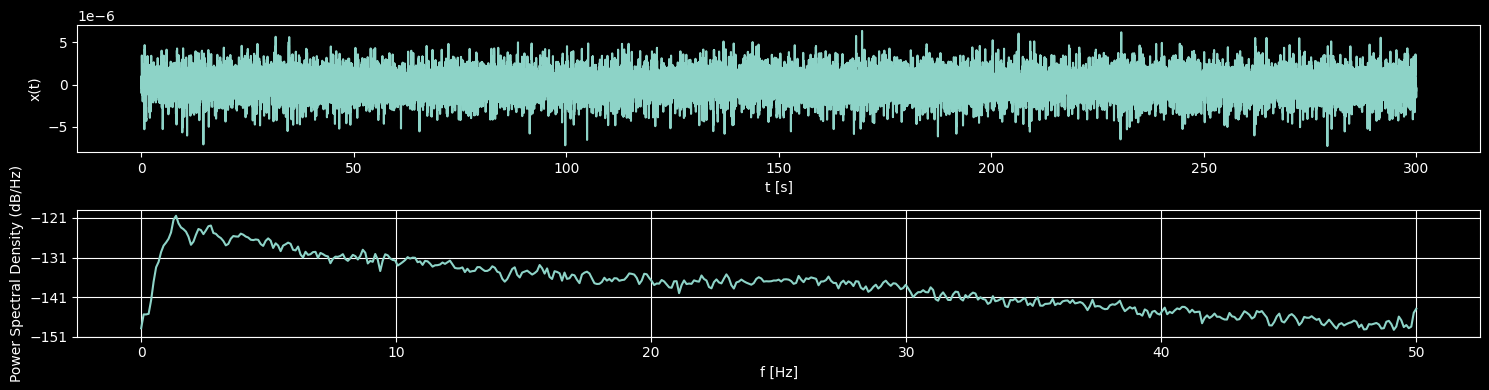

In [67]:
subject = 15
channel = 12
plot_psd(data_tensor, subject=subject, channel=channel, fs=fs)

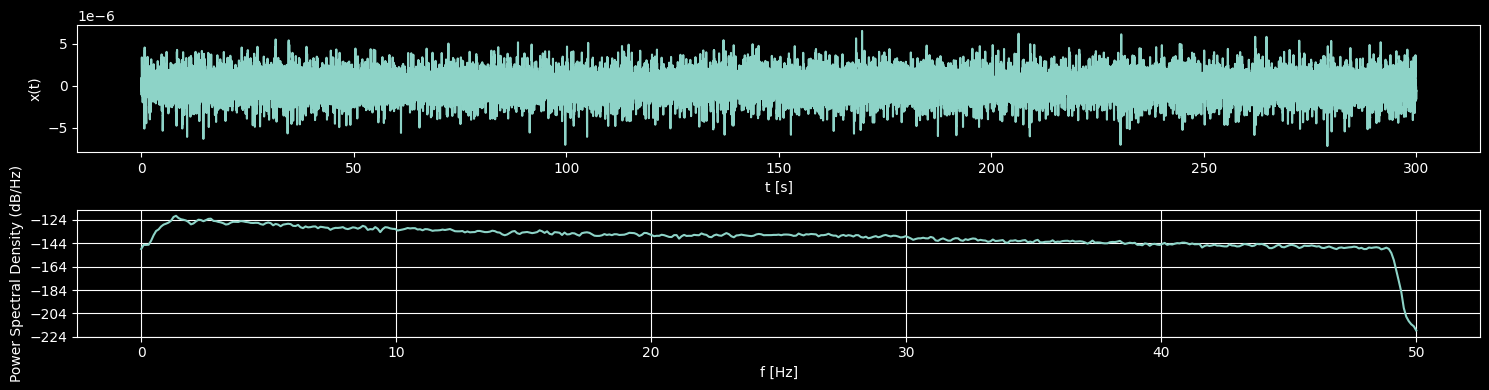

In [68]:
plot_psd(data_filtered_lp, subject=subject, channel=channel, fs=fs)

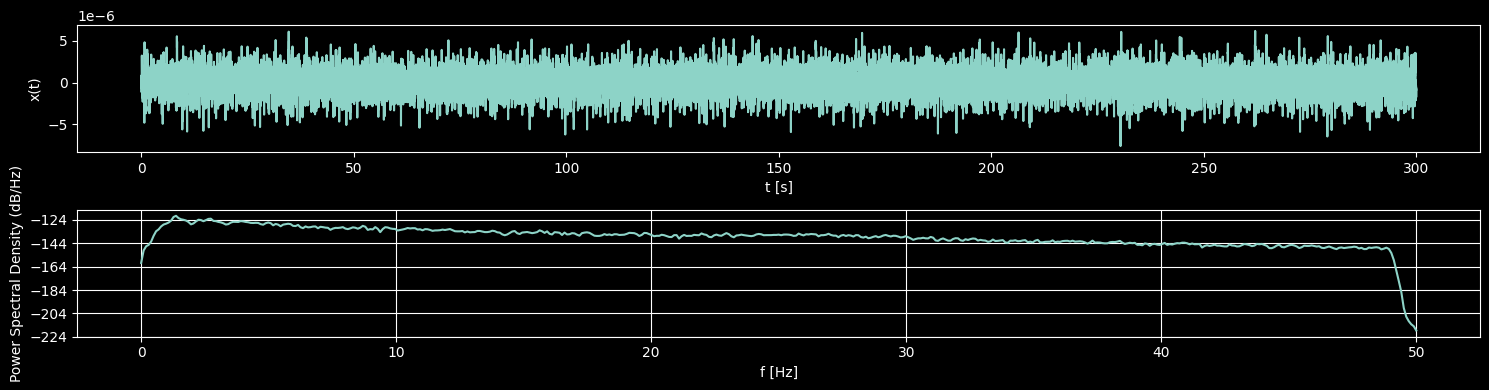

In [69]:
plot_psd(data_filtered_lp_hp, subject=subject, channel=channel, fs=fs)

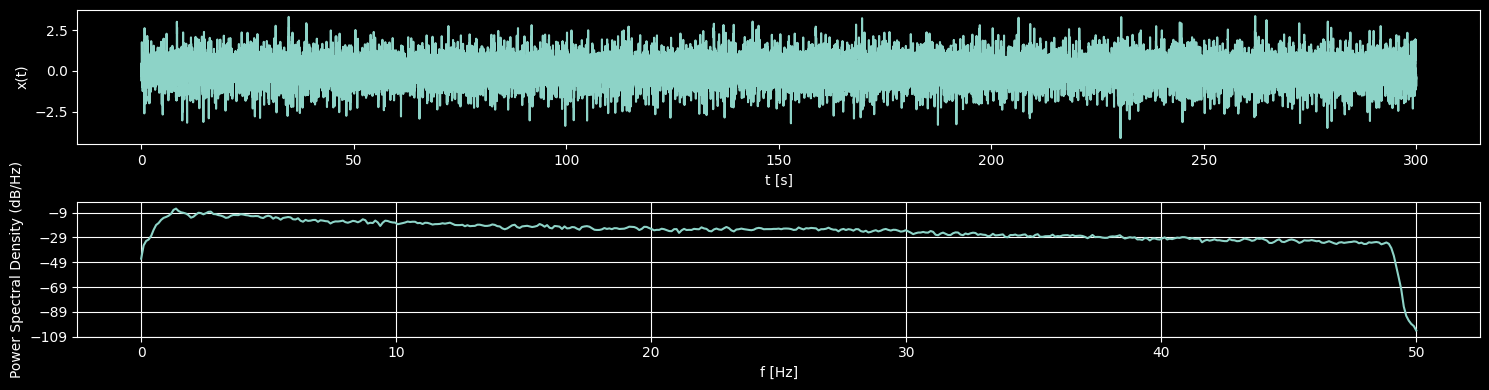

In [70]:
plot_psd(data_normalized, subject=subject, channel=channel, fs=fs)

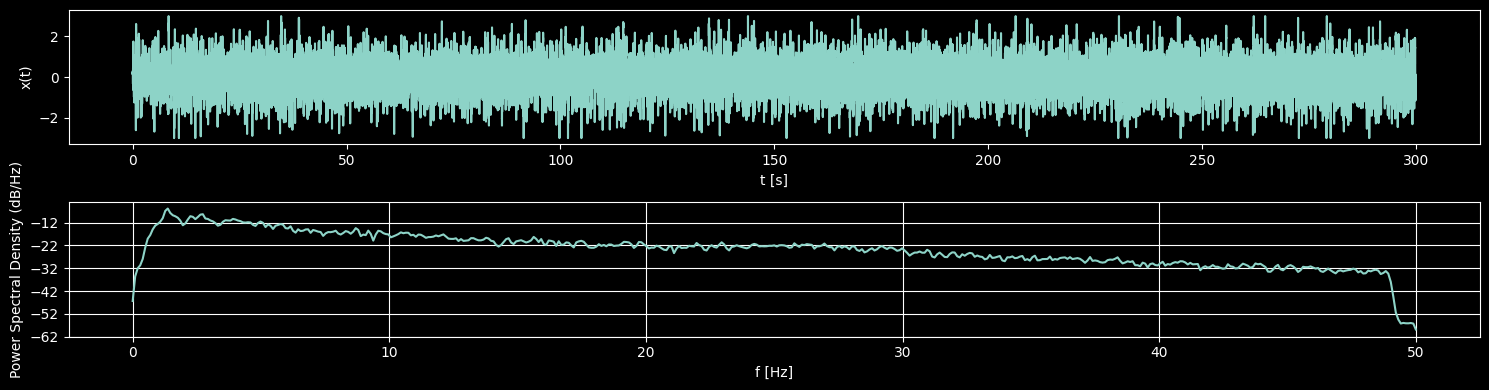

In [71]:
plot_psd(data_clamped, subject=subject, channel=channel, fs=fs)

In [184]:
labels_val_tensor[subject]

tensor([62.5000])

### Visualize data distribution

In [6]:
labels_train_tensor = torch.load("/home/oturgut/data/processed/lemon/labels_raw_train.pt")
labels_val_tensor = torch.load("/home/oturgut/data/processed/lemon/labels_raw_val.pt")
labels_test_tensor = torch.load("/home/oturgut/data/processed/lemon/labels_raw_test.pt")

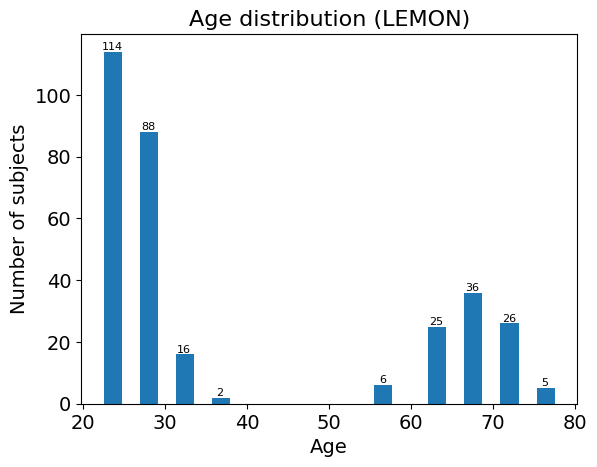

In [16]:
# Generate example data
data = torch.cat([labels_train_tensor, labels_val_tensor, labels_test_tensor], dim=0).squeeze()

# Create a histogram
counts, bins, _ = plt.hist(data, bins=25)

# Add text annotations for non-zero absolute counts above each bar
for count, bin_edge in zip(counts, bins):
    if count != 0:
        plt.text(bin_edge + 1, count, str(int(count)), ha='center', va='bottom', fontsize=8, color='black')

# Add labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of subjects', fontsize=14)
plt.title('Age distribution (LEMON)', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('./figures/age_dist_lemon_all.png', transparent=True)

# Show the plot
plt.show()


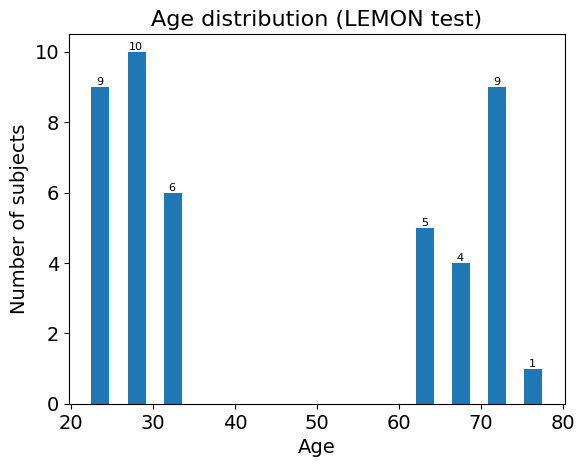

In [18]:
# Generate example data
data = labels_test_tensor.squeeze()

# Create a histogram
counts, bins, _ = plt.hist(data, bins=25)

# Add text annotations for non-zero absolute counts above each bar
for count, bin_edge in zip(counts, bins):
    if count != 0:
        plt.text(bin_edge + 1, count, str(int(count)), ha='center', va='bottom', fontsize=8, color='black')

# Add labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of subjects', fontsize=14)
plt.title('Age distribution (LEMON test)', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('./figures/age_dist_lemon_test.png', transparent=True)

# Show the plot
plt.show()
